# Project 4: Humanizing Customer Complaints 

# Section 1: Importing Packages and Loading Data

In [ ]:
import numpy as np
import pandas as pd
seed = 69 # set random seed for whole document

# Graph plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Displaying dataframes
from IPython.display import display

# Natural Language Processing Thingamajibs
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from gensim.models import Word2Vec, word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import gensim

# Classifiers
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Metrics to score classifiers
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve, log_loss

# Data splitting, CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

# Lifesaver
import pickle

In [ ]:
# Load CSV file
df = pd.read_csv('Consumer_Complaints.csv')

## Section 1.1: Data Cleaning

In [ ]:
# Column Cleaning First. Columns are super nastily named
df.rename(columns={'Date received':'DATE_RECEIVED',
                  'Product':'PRODUCT',
                  'Sub-product':'SUB_PRODUCT',
                  'Issue':'ISSUE',
                  'Sub-issue':'SUB_ISSUE',
                  'Consumer complaint narrative':'CONSUMER_COMPLAINT_NARRATIVE',
                  'Company public response':'COMPANY_PUBLIC_RESPONSE',
                   'Company':'COMPANY',
                   'State':'STATE',
                   'ZIP code':'ZIP_CODE',
                   'Tags':'TAGS',
                   'Consumer consent provided?':'CONSUMER_CONSENT_PROVIDED',
                   'Subbmited via':'SUBMITTED_VIA',
                   'Date sent to company':'DATE_SENT_TO_COMPANY',
                   'Company response to consumer':'COMPANY_RESPONSE_TO_CONSUMER',
                   'Timely response?':'TIMELY_RESPONSE',
                   'Consumer disputed?':'CONSUMER_DISPUTED',
                   'Complaint ID':'COMPLAINT_ID'
                  }, inplace=True)


In [ ]:
# Since we just want to do text classification with an associated label
# We only keep rows that have customer complaints in them

### Section 1.1.1: Dropping all rows that do not have Customer Complaint entries in them

In [ ]:
df.dropna(axis=0, subset=['CONSUMER_COMPLAINT_NARRATIVE'], 
          inplace=True)

### Section 1.1.2: Subsetting Dataframe for Text Multi-Classification Problem

In [ ]:
# Subsetting dataframe into columns useful for our text multi-classification problem
df_product_and_complaint = df[['PRODUCT', 'CONSUMER_COMPLAINT_NARRATIVE']]

# Renaming columns to something easier
df_product_and_complaint.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 
df.rename(columns={'CONSUMER_COMPLAINT_NARRATIVE':'CONSUMER_COMPLAINT'},inplace=True) 

In [ ]:
# # Pickling our subsetted dataframe
# with open('df_product_and_complaint.pickle', 'wb') as to_write:
#     pickle.dump(df_product_and_complaint, to_write)

In [2]:
# Loading our pickled subsetted dataframe
with open('df_product_and_complaint.pickle', 'rb') as to_read:
    df_product_and_complaint = pickle.load(to_read)

# Section 2: Understanding/Cleaning Our Data

In [9]:
# Checking our dataframe
df_product_and_complaint.info()

# Great! We have no null values in each column

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463991 entries, 4 to 1437711
Data columns (total 2 columns):
PRODUCT               463991 non-null object
CONSUMER_COMPLAINT    463991 non-null object
dtypes: object(2)
memory usage: 10.6+ MB


### We have a wooping 463,991 entries in our dataframe.
This might cause our comptuer to crash. So we gotta reduce it.

In [10]:
# Now let's take a look at some observations of what these rows look like
df_product_and_complaint.head(5)

,PRODUCT,CONSUMER_COMPLAINT
4,Credit card,I am dissatisfied with the current outcome of ...
8,"Credit reporting, credit repair services, or o...",On XX/XX/18 an item showed up on my credit rep...
9,Debt collection,Saw on my credit report that there is a collec...
10,"Credit reporting, credit repair services, or o...",Capital one auto finacing XX/XX/2018 unknown i...
12,Credit card or prepaid card,I own a small trucking company. One of my truc...


## Section 2.1: Exploring Consumer Complaints

In [8]:
# # What do a few of the entries in the consumer complaint section look like?

# df_credit_card = df_product_and_complaint[df_product_and_complaint['PRODUCT'] == 'Credit card']
# df_credit_card.rename(columns={'PRODUCT': 'Credit card'}, inplace=True)

# for complaint in df_credit_card.CONSUMER_COMPLAINT[:2]:
#     print(complaint)
#     print('\n')

### Jesus christ, it doesn't seem like we can glean anything very well from this wall of text either.
1. It is **immensely hard to read** because it's so long (that's what she said)   

2. Therefore, by being able to automatically correctly categorize/file customer complaints into their respective complaint type (credit reporting, loan complaint, etc.) **with just the customer input**, we can reduce the amount of computational stress and effort of an individual human.  
  
3. Additionally, a further step we can take is to have our program do some kind of summarization or pseudo-summarization (tf-idf) on the whole wall of text that one has to read.

**Therefore, we verify our model based on accuracy this time.**


## Section 2.2: Exploring Product

In [11]:
# Exploring the number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint['PRODUCT'].nunique())
print('--------------')

--------------
Categories in PRODUCT column:
--------------

['Credit card'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Credit card or prepaid card' 'Mortgage'
 'Bank account or service' 'Credit reporting' 'Student loan'
 'Checking or savings account' 'Vehicle loan or lease' 'Consumer Loan'
 'Money transfer, virtual currency, or money service' 'Money transfers'
 'Payday loan' 'Payday loan, title loan, or personal loan'
 'Other financial service' 'Prepaid card' 'Virtual currency'] 

--------------
# of unique categories:  18
--------------


### We see that some of the categories are repeated.
* 'Credit card' vs 'Credit card or prepaid card'
* 'Prepaid card' vs 'Credit card or prepaid card'
* 'Credit reporting' vs 'Credit reporting, credit repair services, or other personal consumer reports'
* 'Money transfers' vs 'Money transfer, virtual currency, or money service'
* 'Payday loan' vs 'Payday loan, title loan, or personal loan'
* 'Virtual currency' vs 'Money transfer, virtual currency, or money service' 'Money transfers'

There seems to be some sort of overlap between the categories, and I have no freakin clue why it is put this way. So why don't we simplify our problem by combining these categories together?  
  
But of course - let us do some **data visualizations** to gain more insights about the spread of our categories, shall we? 
  
### OMG WOW DATA VISUALIZATION YOU SAY??

In [10]:
# yea boi. data viz

### Section 2.2.1: Data Visualization on Categories in PRODUCT

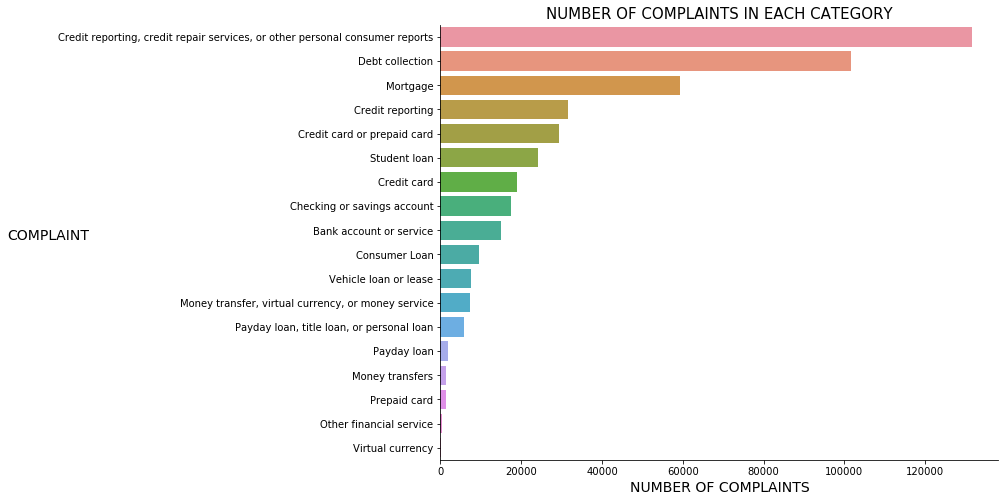

In [12]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, size=14, labelpad=10)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
            
plt.savefig('freq_of_uncombined_class.png', transparency=True)

In [13]:
print('Number of rows in Dataframe: ', len(df_product_and_complaint))


Number of rows in Dataframe:  463991


This is seriously way too huge. Let's just scope our problem down into more bite-sized chunks our computer can actually handle.

### We observe some aggregated columns here.
Let's drop those columns first. Since we want a more accurate/specific label for our predictions. The columns are:
* Credit reporting, credit repair services, or other personal consumer reports
* Credit card or prepaid card
* Money transfer, virtual currency, or money service
* Payday loan, title loan, or personal loan

### Section 2.2.2: DataFrame Reduction (else we won't even be able to do processing)

#### Section 2.2.2.1: Category Dropping

In [3]:
# Pre-drop category value_counts
df_product_and_complaint.PRODUCT.value_counts()

Credit reporting, credit repair services, or other personal consumer reports    131526
Debt collection                                                                 101580
Mortgage                                                                         59362
Credit reporting                                                                 31588
Credit card or prepaid card                                                      29263
Student loan                                                                     24243
Credit card                                                                      18838
Checking or savings account                                                      17582
Bank account or service                                                          14885
Consumer Loan                                                                     9473
Vehicle loan or lease                                                             7570
Money transfer, virtual currency, or money 

In [3]:
# Dropping rows with the aggregated columns
df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit reporting, credit repair services, or other personal consumer reports'].index, 
    inplace=True) # credit_aggregated

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Credit card or prepaid card'].index, 
    inplace=True) # cred_or_prepaid

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Money transfer, virtual currency, or money service'].index, 
    inplace=True) # money_virtual_service

df_product_and_complaint.drop(
    df_product_and_complaint[
    df_product_and_complaint.PRODUCT == 
    'Payday loan, title loan, or personal loan'].index, 
    inplace=True) # payday_title_personal_loan

#### Visualizing Leftover Categories (after dropping the ones stated above)

Text(0.5, 0, 'NUMBER OF COMPLAINTS')

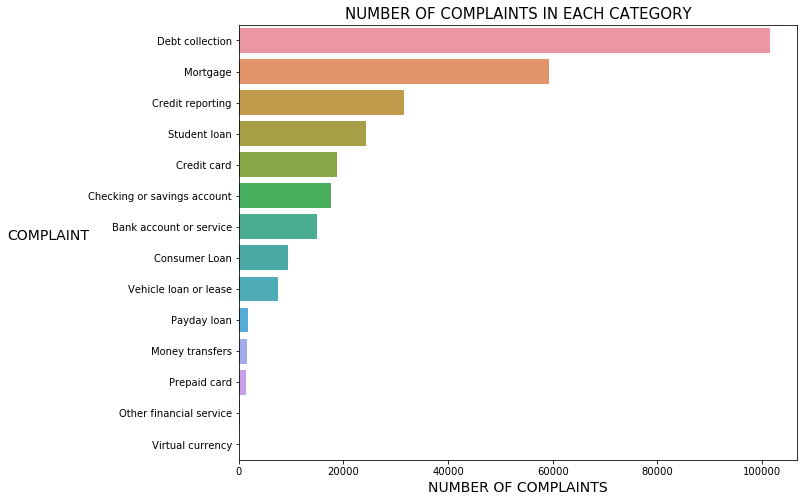

In [16]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint, 
                   order=df_product_and_complaint['PRODUCT'].value_counts().index)

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

In [8]:
# Checking Length of df now
df_product_and_complaint.info()

# It's still quite a sizeable amount that my computer can't take. So we have to drop more.
# We want to reduce it to less than 50k entries

# LOL good job surface pro

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290122 entries, 4 to 1437711
Data columns (total 2 columns):
PRODUCT               290122 non-null object
CONSUMER_COMPLAINT    290122 non-null object
dtypes: object(2)
memory usage: 6.6+ MB


In [5]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                101580
Mortgage                        59362
Credit reporting                31588
Student loan                    24243
Credit card                     18838
Checking or savings account     17582
Bank account or service         14885
Consumer Loan                    9473
Vehicle loan or lease            7570
Payday loan                      1746
Money transfers                  1497
Prepaid card                     1450
Other financial service           292
Virtual currency                   16
Name: PRODUCT, dtype: int64

#### Section 2.2.2.2: Combining Categories

In [4]:
## Combining Loans together to make this a simplier classification problem

df_product_and_complaint.replace('Student loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Consumer Loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Payday loan', 'Loan', inplace=True)
df_product_and_complaint.replace('Vehicle loan or lease', 'Loan', inplace=True)

# Placing Virtual currency into other financial service
df_product_and_complaint.replace('Virtual currency', 'Other financial service', inplace=True)

#### Section 2.2.2.3: Leftover Categories Dataframe Reduction

In [20]:
df_product_and_complaint.PRODUCT.value_counts()

Debt collection                101580
Mortgage                        59362
Loan                            43032
Credit reporting                31588
Credit card                     18838
Checking or savings account     17582
Bank account or service         14885
Money transfers                  1497
Prepaid card                     1450
Other financial service           308
Name: PRODUCT, dtype: int64

In [10]:
df_product_and_complaint.info()  # 290k rows. jesus christ

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290122 entries, 4 to 1437711
Data columns (total 2 columns):
PRODUCT               290122 non-null object
CONSUMER_COMPLAINT    290122 non-null object
dtypes: object(2)
memory usage: 6.6+ MB


In [5]:
# Reducing dataframe to 30k entries
# Need to reduce all categories by 90%

percentage_reduction = 0.9

# Debt Collection Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint.drop(
    df_product_and_complaint[df_product_and_complaint['PRODUCT'] == 'Debt collection'].sample(frac=percentage_reduction).index)

# Mortgage Reduction
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Mortgage'].sample(frac=percentage_reduction).index)

# Loan
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Loan'].sample(frac=percentage_reduction).index)

# Credit reporting
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit reporting'].sample(frac=percentage_reduction).index)

# Credit card
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Credit card'].sample(frac=percentage_reduction).index)

# Checking or savings account
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Checking or savings account'].sample(frac=percentage_reduction).index)

# Bank account or service
df_product_and_complaint_reduced = \
df_product_and_complaint_reduced.drop(
    df_product_and_complaint_reduced[
        df_product_and_complaint_reduced['PRODUCT'] == 'Bank account or service'].sample(frac=percentage_reduction).index)

# # Money transfers (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Money transfers'].sample(frac=.9).index)

# # Prepaid card (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Prepaid card'].sample(frac=.9).index)

# # Other financial service (too little to be reduced)
# df_product_and_complaint_reduced = \
# df_product_and_complaint_reduced.drop(
#     df_product_and_complaint_reduced[
#         df_product_and_complaint_reduced['PRODUCT'] == 'Other financial service'].sample(frac=.9).index)

In [6]:
df_product_and_complaint_reduced.PRODUCT.value_counts()

Debt collection                10158
Mortgage                        5936
Loan                            4303
Credit reporting                3159
Credit card                     1884
Checking or savings account     1758
Money transfers                 1497
Bank account or service         1489
Prepaid card                    1450
Other financial service          308
Name: PRODUCT, dtype: int64

In [7]:
df_product_and_complaint_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31942 entries, 9 to 1437575
Data columns (total 2 columns):
PRODUCT               31942 non-null object
CONSUMER_COMPLAINT    31942 non-null object
dtypes: object(2)
memory usage: 748.6+ KB


In [8]:
# Exploring the new number of mutli-class categories we have
print('--------------')
print('Categories in PRODUCT column:')
print('--------------\n')
print(df_product_and_complaint_reduced['PRODUCT'].unique(), '\n')
print('--------------')
print('# of unique categories: ', df_product_and_complaint_reduced['PRODUCT'].nunique())
print('--------------')

# Great! Now we are down to 10 classes. 

--------------
Categories in PRODUCT column:
--------------

['Loan' 'Checking or savings account' 'Credit reporting' 'Debt collection'
 'Mortgage' 'Credit card' 'Money transfers' 'Other financial service'
 'Bank account or service' 'Prepaid card'] 

--------------
# of unique categories:  10
--------------


### Section 2.2.3: Data Visualizing on newly combined classes

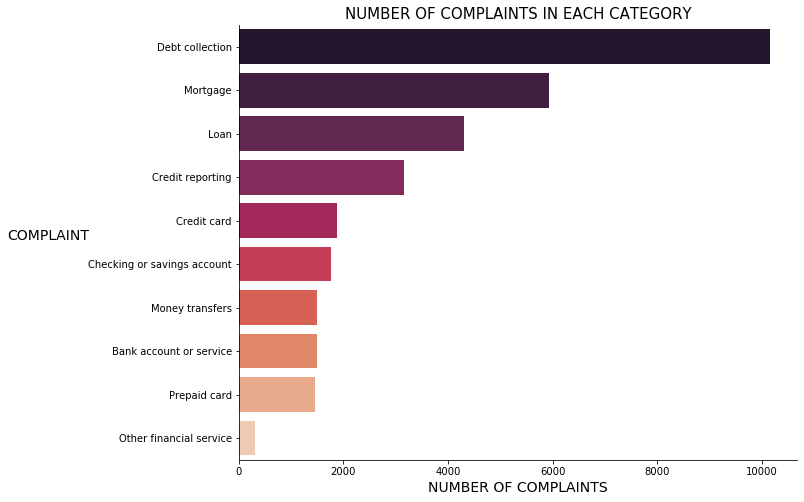

In [26]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint_reduced, 
                   order=df_product_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

We can see from the graph that there lies a major class imbalance (again)  
We have to deal with this when we are going to use our model for prediction  
Now we are doing multilabel prediction. HOORAY!

### Section 2.2.4: Label Encoding Categories

In [8]:
# Applying encoding to the PRODUCT column
df_product_and_complaint_reduced['PRODUCT_ID'] = df_product_and_complaint_reduced['PRODUCT'].factorize()[0] 

#.factorize[0] arranges the index of each encoded number accordingly to the 
# index of your categorical variables in the PRODUCT column


# Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
category_id_df = df_product_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()


# Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

# New dataframe
df_product_and_complaint_reduced.head(10) 

,PRODUCT,CONSUMER_COMPLAINT,PRODUCT_ID
9,Debt collection,Saw on my credit report that there is a collec...,0
62,Debt collection,I received a collection notice and called righ...,0
108,Credit reporting,Because I filed bankruptcy and included the de...,1
116,Credit reporting,Hello I try and keep track of the items that a...,1
153,Loan,"In XX/XX/2018, I applied for a Total and Perma...",2
160,Mortgage,I took out a mortgage with HSBC to buy my home...,3
218,Credit reporting,Several years ago I purchased a car from XXXX ...,1
265,Checking or savings account,"This morning, XX/XX/2019 I spoke with M & T Ba...",4
283,Credit reporting,I believed some of the information on my credi...,1
285,Credit card,"Back in 2010, when I was busy with school, wor...",5


In [10]:
# We still get the same length as per the original df.
len(df_product_and_complaint_reduced)

31942

Now that we have encoded our columns, time to move on to the next step -- cleaning the fricken text data  
But let's save our dataframe here so we don't run into memory issues later and we can start from a new starting point fruther down the notebook

In [11]:
# # Pickling reduced dataframe
# with open('df_product_and_complaint_reduced.pickle', 'wb') as to_write:
#     pickle.dump(df_product_and_complaint_reduced, to_write)

### Section 2.2.5: Text Pre-Processing

In [47]:
# Looking at a sample text
sample_complaint = list(df_product_and_complaint.CONSUMER_COMPLAINT[:5])[4]

# Converting to a list for TfidfVectorizer to use
list_sample_complaint = []
list_sample_complaint.append(sample_complaint)
list_sample_complaint

In [111]:
# Observing what words are extracted from a TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf3 = TfidfVectorizer(stop_words='english')
check3 = tf_idf3.fit_transform(list_sample_complaint)

print(tf_idf3.get_feature_names())

['18', '2018', 'access', 'account', 'additionally', 'automatically', 'better', 'billing', 'checks', 'company', 'complaint', 'consistently', 'contacted', 'conversion', 'copy', 'correspondence', 'current', 'customer', 'cycle', 'deducted', 'deliberating', 'did', 'dual', 'end', 'epay', 'escrow', 'explained', 'funds', 'generated', 'hard', 'information', 'initially', 'late', 'loan', 'mailed', 'maintain', 'make', 'month', 'monthly', 'months', 'mortgage', 'needed', 'new', 'noted', 'occurring', 'online', 'payment', 'payments', 'posted', 'posting', 'prior', 'probably', 'processed', 'provided', 'provider', 'reached', 'received', 'reflecting', 'regards', 'sent', 'service', 'servicing', 'set', 'shortage', 'showing', 'sold', 'spoke', 'stated', 'statement', 'statements', 'submitting', 'suntrust', 'taking', 'time', 'told', 'trying', 'understand', 'understanding', 'understood', 'visited', 'website', 'withdrawn', 'xx', 'xxxx']


Ok so basically, we can trust the stop_word removal from tfidf.   
Through the tests, we see that it removes punctuations and also all the stopwords.   
(I deleted these because they were seriously taking up a lot of space on my jupyter notebook)  
Spellchecker might also mess up some words, especially with bank names like Citi for example  
Thus changing the semantic meaning of the word.  
  
Therefore, we are going to just use tfidf just as it is.  
It's pretty amazing, really.  
  
Great! We can start building some shit!  

# Section 3: Model/Classifier Selection

## Section 3.1: Train/StratifiedCV/Test split

In this section, we also prepare the model for text pre-processing. This is handled by our handydandy Tfidfvecotirzer with the stop_words and such. As we have tested above, it also ignores punctuation so it really is quite a catch-all package that cleans our text really well for the purposes of doing text classification

In [3]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

X shape: (31942,) y shape: (31942,)


In [4]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT_ID
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (25553,)
y_train (25553,)
X_test (6389,)
y_test (6389,)


In [5]:
# Performing Text Pre-Processing

# Import tfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Text Preprocessing
# The text needs to be transformed to vectors so as the algorithms will be able make predictions. 
# In this case it will be used the Term Frequency – Inverse Document Frequency (TFIDF) weight 
# to evaluate how important A WORD is to A DOCUMENT in a COLLECTION OF DOCUMENTS.

# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')

X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')
X_train_val_tfidf2 = tfidf2.fit_transform(X_train_val).toarray()
X_test_tfidf2 = tfidf2.transform(X_test)


# # StratifiedKFold -> Split 5
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)

# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Section 3.2: Baseline Model - Train/Stratified CV with MultinomialNB()

In [8]:
print('1-gram number of (rows, features):', X_train_val_tfidf1.shape)

In [5]:
def metric_cv_stratified(model, X_train_val, y_train_val, n_splits, name):
    """
    Accepts a Model Object, converted X_train_val and y_train_val, n_splits, name
    and returns a dataframe with various cross-validated metric scores 
    over a stratified n_splits kfold for a multi-class classifier.
    """
    # Start timer
    import timeit
    start = timeit.default_timer()
    
    ### Computations below
    
    # StratifiedKFold
    ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
    # (number is split evenly from all the classes)
    from sklearn.model_selection import StratifiedKFold  # incase user forgest to import
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    
    # Initializing Metrics
    accuracy = 0.0
    micro_f1 = 0.0
    macro_precision = 0.0
    macro_recall = 0.0
    macro_f1 = 0.0
    weighted_precision = 0.0
    weighted_recall = 0.0
    weighted_f1 = 0.0
#     roc_auc = 0.0    Not considering this score in this case
        
    # Storing metrics
    from sklearn.model_selection import cross_val_score  # incase user forgets to import
    accuracy = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='accuracy'))
#     micro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_micro'))
    macro_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_macro'))
    macro_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_macro'))
    macro_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_macro'))
    weighted_precision = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='precision_weighted'))
    weighted_recall = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='recall_weighted'))
    weighted_f1 = np.mean(cross_val_score(model, X_train_val, y_train_val, cv=kf, scoring='f1_weighted'))
    
    # Stop timer
    stop = timeit.default_timer()
    elapsed_time = stop - start
    
    return pd.DataFrame({'Model'    : [name],
                         'Accuracy' : [accuracy],
#                          'Micro F1' : [micro_f1],
                         'Macro Precision': [macro_precision],
                         'Macro Recall'   : [macro_recall],
                         'Macro F1score'  : [macro_f1],
                         'Weighted Precision': [weighted_precision],
                         'Weighted Recall'   : [weighted_recall],
                         'Weighted F1'  : [weighted_f1],
                         'Time taken': [elapsed_time]  # timetaken: to be used for comparison later
                        })

In [ ]:
# ## Data Science Story:
# # Testing on MultinomialNB first

# # Initialize Model Object
# mnb = MultinomialNB()

# results_cv_stratified_1gram = metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1')
# results_cv_stratified_2gram = metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2')

In [ ]:
# results_cv_stratified_1gram

In [ ]:
# results_cv_stratified_2gram

## Section 3.3: Further Train/Straitified CV with other Models

### Section 3.3.1: 1-gram

In [21]:
## Testing on all Models using 1-gram 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_1gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf1, y_train_val, 5, 'MultinomialNB1'),
                                           metric_cv_stratified(gnb, X_train_val_tfidf1, y_train_val, 5, 'GaussianNB1'),
                                           metric_cv_stratified(logit, X_train_val_tfidf1, y_train_val, 5, 'LogisticRegression1'),
                                           metric_cv_stratified(randomforest, X_train_val_tfidf1, y_train_val, 5, 'RandomForest1'),
                                           metric_cv_stratified(linearsvc, X_train_val_tfidf1, y_train_val, 5, 'LinearSVC1')
                                          ], axis=0).reset_index()

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\xianj\Anaconda3\envs\m

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users

In [23]:
results_cv_straitified_1gram

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,MultinomialNB1,0.697606,0.722300,0.469503,0.514230,0.740166,0.697606,0.660828,155.774410
1,0,GaussianNB1,0.399716,0.309925,0.324989,0.309975,0.438525,0.399716,0.408915,682.608477
2,0,LogisticRegression1,0.828629,0.790309,0.695758,0.708572,0.824296,0.828629,0.821059,225.600873
3,0,RandomForest1,0.437093,0.225024,0.167247,0.141720,0.416938,0.437093,0.325136,866.157337
4,0,LinearSVC1,0.824754,0.774695,0.717642,0.732412,0.820596,0.824754,0.820706,194.756212


In [24]:
# # Saving our results because I don't wanna re-train the whole damn thing
# with open('results_cv_straitified_1gram_df.pickle', 'wb') as to_write:
#     pickle.dump(results_cv_straitified_1gram, to_write)

In [6]:
# Loading our pickled results
with open('results_cv_straitified_1gram_df.pickle', 'rb') as to_read:
    results_cv_straitified_1gram = pickle.load(to_read)

### Section 3.3.2: 2-gram (Keep running into memory issues, therefore, this will not be tested anymore)

In [9]:
#### Keep running into memory issues with 2-gram. Therefore, will not test it anymore


## Testing on all Models using 2-gram 

# # Initialize Model Object
# gnb = GaussianNB()
# mnb = MultinomialNB()
# logit = LogisticRegression(random_state=seed)
# knn = KNeighborsClassifier()
# decisiontree = DecisionTreeClassifier(random_state=seed)
# randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
# linearsvc = LinearSVC()

# # to concat all models
# results_cv_straitified_2gram = pd.concat([metric_cv_stratified(mnb, X_train_val_tfidf2, y_train_val, 5, 'MultinomialNB2'),
#                                            metric_cv_stratified(gnb, X_train_val_tfidf2, y_train_val, 5, 'GaussianNB2'),
#                                            metric_cv_stratified(logit, X_train_val_tfidf2, y_train_val, 5, 'LogisticRegression2'),
#                                            metric_cv_stratified(randomforest, X_train_val_tfidf2, y_train_val, 5, 'RandomForest2'),
#                                            metric_cv_stratified(linearsvc, X_train_val_tfidf2, y_train_val, 5, 'LinearSVC2')
#                                           ], axis=0).reset_index()

In [ ]:
# results_cv_straitified_2gram

### Section 3.3.3: Using GloVe50d

Each complaint is mapped to a feature vector by averaging the word embeddings of all words in the review. These features are then fed into the defined function above for train/cross validation.

In [6]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

glove_file = glove_dir = 'glove.6B.50d.txt'
w2v_output_file = 'glove.6B.50d.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_50d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_50d.pickle', 'wb') as to_write:
    pickle.dump(glove_model_50d, to_write)

In [7]:
# Load pickled glove_model
with open('glove_model_50d.pickle', 'rb') as to_read:
    glove_model_50d = pickle.load(to_read)
    
num_features = 50 # depends on the pre-trained model you are loading

In [8]:
def complaint_to_wordlist(review, remove_stopwords=False):
    """
    Convert a complaint to a list of words. Removal of stop words is optional.
    """
    # remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review)
    
    # convert to lower case and split at whitespace
    words = review_text.lower().split()
    
    # remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return words    # list of tokenized and cleaned words

In [9]:
# num_features refer to the dimensionality of the model you are using
# model refers to the trained word2vec/glove model
# words refer to the words in a single document/entry

def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),  # creates a zero matrix of (num_features, )
                           dtype="float32")  # pre-initialize (for speed)
    
    # Initialize a counter for the number of words in a complaint
    nwords = 0.
    index2word_set = set(model.index2word)  # words known to the model

    
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:   # for each word in the list of words
        if word in index2word_set:   # if each word is found in the words known to the model
            nwords = nwords + 1.     # add 1 to nwords
            feature_vec = np.add(feature_vec, model[word])   
    
    # Divide by the number of words to get the average 
    if nwords > 0:
        feature_vec = np.divide(feature_vec, nwords)
    
    return feature_vec

In [10]:
# complaints refers to the whole corpus you intend to put in. 
# Therefore you need to append all these info from your df into a list first

def get_avg_feature_vecs(complaints, model, num_features):
    """
    Calculate average feature vectors for ALL complaints
    """
    # Initialize a counter for indexing 
    counter = 0
    
    # pre-initialize (for speed)
    complaint_feature_vecs = np.zeros((len(complaints),num_features), dtype='float32')  
    
    for complaint in complaints: # each complaint is made up of tokenized/cleaned/stopwords removed words
        complaint_feature_vecs[counter] = make_feature_vec(complaint, model, num_features)
        counter = counter + 1
    return complaint_feature_vecs

In [12]:
# Tokenizing and vectorizing our Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_50d, num_features)

# Tokenizing and vectorizing our Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_50d, num_features)

In [31]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove50d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove50d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove50d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove50d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove50d')
    ], axis=0).reset_index()

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logisti

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklea

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classificati

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\me

In [33]:
# Saving Results into a DF
with open('results_cv_straitified_glove50d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove50d, to_write)

In [7]:
# Opening Results
with open('results_cv_straitified_glove50d.pickle', 'rb') as to_read:
    results_cv_straitified_glove50d = pickle.load(to_read)

In [34]:
results_cv_straitified_glove50d

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,GaussianNB_glove50d,0.409619,0.340044,0.363948,0.333497,0.465932,0.409619,0.417328,2.242258
1,0,LogisticRegression_glove50d,0.620441,0.534684,0.443491,0.470695,0.608947,0.620441,0.599789,211.892368
2,0,RandomForest_glove50d,0.451142,0.248807,0.196028,0.182891,0.397285,0.451142,0.363031,224.648648
3,0,LinearSVC_glove50d,0.627796,0.529956,0.450536,0.466225,0.611326,0.627796,0.602756,826.272552


### Section 3.3.4: Using GloVe100d

In [36]:
del glove_model_50d, results_cv_straitified_glove50d

In [44]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 100 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_100d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_100d, to_write)

In [45]:
# Load pickled glove_model
with open('glove_model_100d.pickle', 'rb') as to_read:
    glove_model_100d = pickle.load(to_read)

In [46]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_100d, num_features)

# For Test Complaints (20%)
clean_test_complaints = []
for complaint in X_train_val:
    clean_test_complaints.append(complaint_to_wordlist(complaint, True))

X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_100d, num_features)

In [47]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove100d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove100d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove100d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove100d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove100d')
    ], axis=0).reset_index()

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logisti

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:4

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classificati

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\

In [49]:
with open('results_cv_straitified_glove100d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove100d, to_write)

In [10]:
# Opening Results
with open('results_cv_straitified_glove100d.pickle', 'rb') as to_read:
    results_cv_straitified_glove100d = pickle.load(to_read)

In [50]:
results_cv_straitified_glove100d

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,GaussianNB_glove100d,0.403516,0.357448,0.392785,0.352718,0.488544,0.403516,0.419800,3.426242
1,0,LogisticRegression_glove100d,0.702779,0.618626,0.541032,0.561818,0.690619,0.702779,0.688432,211.917178
2,0,RandomForest_glove100d,0.449341,0.317780,0.195554,0.184018,0.437539,0.449341,0.353212,267.022990
3,0,LinearSVC_glove100d,0.705830,0.616116,0.547209,0.558881,0.692501,0.705830,0.689030,960.394804


### Section 3.3.5: Using GloVe200d

In [51]:
del glove_model_100d, results_cv_straitified_glove100d

In [52]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 200 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_200d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_200d, to_write)

In [53]:
# Load pickled glove_model
with open('glove_model_200d.pickle', 'rb') as to_read:
    glove_model_200d = pickle.load(to_read)

In [64]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_200d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [65]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove200d = pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove200d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove200d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove200d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove200d')
    ], axis=0).reset_index()

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logisti

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classificati

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:4

C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\User\.conda\envs\metis\lib\site-packages\sklearn\metrics\classification.py:1437: Unde

In [66]:
with open('results_cv_straitified_glove200d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove200d, to_write)

In [11]:
# Opening Results
with open('results_cv_straitified_glove200d.pickle', 'rb') as to_read:
    results_cv_straitified_glove200d = pickle.load(to_read)

In [67]:
results_cv_straitified_glove200d

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,GaussianNB_glove200d,0.436466,0.407750,0.428555,0.392526,0.544428,0.436466,0.462505,6.714138
1,0,LogisticRegression_glove200d,0.746569,0.662747,0.593125,0.608057,0.734934,0.746569,0.734741,381.070067
2,0,RandomForest_glove200d,0.471257,0.325161,0.201373,0.179069,0.466755,0.471257,0.363945,432.460056
3,0,LinearSVC_glove200d,0.752361,0.659053,0.600848,0.608231,0.739292,0.752361,0.739326,2072.531616


### Section 3.3.6: Using GloVe300d

In [68]:
del glove_model_200d, results_cv_straitified_glove200d

In [69]:
## Using pre-trained GloVe
# download from https://nlp.stanford.edu/projects/glove/

num_features = 300 # depends on the pre-trained model you are loading

glove_file = glove_dir = 'glove.6B.' + str(num_features) + 'd.txt'
w2v_output_file = 'glove.6B.' + str(num_features) + 'd.txt.w2v'

# The following utility converts file formats
gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)

# Now we can load it!
glove_model_300d = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)

# Pickle glove model so we don't have to do the above steps again and keep the damn glove.6b.50d in our folder
with open('glove_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(glove_model_300d, to_write)

In [70]:
# Load pickled glove_model
with open('glove_model_300d.pickle', 'rb') as to_read:
    glove_model_300d = pickle.load(to_read)

In [71]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, glove_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [ ]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_glove300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_glove300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_glove300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_glove300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_glove300d')
    ], axis=0).reset_index()

In [73]:
with open('results_cv_straitified_glove300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_glove300d, to_write)

In [13]:
# Opening Results
with open('results_cv_straitified_glove300d.pickle', 'rb') as to_read:
    results_cv_straitified_glove300d = pickle.load(to_read)

In [74]:
results_cv_straitified_glove300d

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,GaussianNB_glove300d,0.432671,0.410793,0.434400,0.393114,0.559452,0.432671,0.463135,10.396090
1,0,LogisticRegression_glove300d,0.763827,0.721214,0.614512,0.628544,0.756583,0.763827,0.753129,494.639791
2,0,RandomForest_glove300d,0.480648,0.382350,0.206346,0.190744,0.502321,0.480648,0.379888,458.303674
3,0,LinearSVC_glove300d,0.771029,0.716528,0.627200,0.636283,0.762243,0.771029,0.759973,2411.613213


### Section 3.3.7: Using GoogleNews Word2Vec300d

In [75]:
del glove_model_300d, results_cv_straitified_glove300d

In [76]:
## Using pre-trained GoogleNews Word2Vec
# download from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

num_features = 300 # depends on the pre-trained model you are loading

# Path to where the word2vec file lives
google_vec_file = 'GoogleNews-vectors-negative300.bin'

# Load it!  This might take a few minutes...
word2vec_model_300d = gensim.models.KeyedVectors.load_word2vec_format(google_vec_file, binary=True)
# it is just loading all the different weights (embedding) into python


# Pickle word2vec 300d model so we don't have to do the above steps again and keep the damn file in our folder
with open('word2vec_model_' + str(num_features) + 'd.pickle', 'wb') as to_write:
    pickle.dump(word2vec_model_300d, to_write)

In [77]:
# Load pickled glove_model
with open('word2vec_model_300d.pickle', 'rb') as to_read:
    word2vec_model_300d = pickle.load(to_read)

In [78]:
# For Train_Val Complaints (80%)
clean_train_val_complaints = []
for complaint in X_train_val:
    clean_train_val_complaints.append(complaint_to_wordlist(complaint, True))

X_train_val_glove_features = get_avg_feature_vecs(clean_train_val_complaints, word2vec_model_300d, num_features)

# Already run above
# # For Test Complaints (20%)
# clean_test_complaints = []
# for complaint in X_train_val:
#     clean_test_complaints.append(complaint_to_wordlist(complaint, True))

# X_test_glove_features = get_avg_feature_vecs(clean_test_complaints, glove_model_200d, num_features)

In [79]:
## Run the X_train_val_word2vec_features into our defined function for scoring 

# Initialize Model Object
gnb = GaussianNB()
mnb = MultinomialNB()
logit = LogisticRegression(random_state=seed)
randomforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
linearsvc = LinearSVC()

## We do NOT want these two. They take FOREVER to train AND predict
# knn = KNeighborsClassifier()  
# decisiontree = DecisionTreeClassifier(random_state=seed)

# to concat all models
results_cv_straitified_word2vec300d= pd.concat([
#     metric_cv_stratified(mnb, X_train_val_glove_features, y_train_val, 5, 'MultinomialNB_glove50d'),
     metric_cv_stratified(gnb, X_train_val_glove_features, y_train_val, 5, 'GaussianNB_word2vec300d'),
     metric_cv_stratified(logit, X_train_val_glove_features, y_train_val, 5, 'LogisticRegression_word2vec300d'),
     metric_cv_stratified(randomforest, X_train_val_glove_features, y_train_val, 5, 'RandomForest_word2vec300d'),
     metric_cv_stratified(linearsvc, X_train_val_glove_features, y_train_val, 5, 'LinearSVC_word2vec300d')
    ], axis=0).reset_index()

In [80]:
with open('results_cv_straitified_word2vec300d.pickle', 'wb') as to_write:
    pickle.dump(results_cv_straitified_word2vec300d, to_write)

In [15]:
# Opening Results
with open('results_cv_straitified_word2vec300d.pickle', 'rb') as to_read:
    results_cv_straitified_word2vec300d = pickle.load(to_read)

In [16]:
results_cv_straitified_word2vec300d

,index,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,0,GaussianNB_word2vec300d,0.462022,0.440222,0.453180,0.420936,0.577487,0.462022,0.492835,11.035332
1,0,LogisticRegression_word2vec300d,0.744963,0.630964,0.585320,0.600587,0.729354,0.744963,0.731291,356.777384
2,0,RandomForest_word2vec300d,0.475678,0.438624,0.199697,0.174722,0.512870,0.475678,0.363007,474.810438
3,0,LinearSVC_word2vec300d,0.763983,0.697031,0.619604,0.624424,0.753017,0.763983,0.751898,474.778550


In [82]:
del word2vec_model_300d, results_cv_straitified_word2vec300d

### Section 3.3.8: Compiling Results

In [26]:
results_compiled.columns

Index(['level_0', 'index', 'Model', 'Accuracy', 'Macro Precision',
       'Macro Recall', 'Macro F1score', 'Weighted Precision',
       'Weighted Recall', 'Weighted F1', 'Time taken'],
      dtype='object')

In [30]:
results_compiled = pd.concat([results_cv_straitified_1gram,
                           results_cv_straitified_glove50d,
                           results_cv_straitified_glove100d,
                           results_cv_straitified_glove200d,
                           results_cv_straitified_glove300d,
                           results_cv_straitified_word2vec300d]).reset_index().drop(['level_0','index'],axis=1)

In [46]:
with open('results_compiled.pickle', 'wb') as to_write:
    pickle.dump(results_compiled, to_write)

results_compiled

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
0,MultinomialNB1,0.697606,0.722300,0.469503,0.514230,0.740166,0.697606,0.660828,155.774410
1,GaussianNB1,0.399716,0.309925,0.324989,0.309975,0.438525,0.399716,0.408915,682.608477
2,LogisticRegression1,0.828629,0.790309,0.695758,0.708572,0.824296,0.828629,0.821059,225.600873
3,RandomForest1,0.437093,0.225024,0.167247,0.141720,0.416938,0.437093,0.325136,866.157337
4,LinearSVC1,0.824754,0.774695,0.717642,0.732412,0.820596,0.824754,0.820706,194.756212
5,GaussianNB_glove50d,0.409619,0.340044,0.363948,0.333497,0.465932,0.409619,0.417328,2.242258
6,LogisticRegression_glove50d,0.620441,0.534684,0.443491,0.470695,0.608947,0.620441,0.599789,211.892368
7,RandomForest_glove50d,0.451142,0.248807,0.196028,0.182891,0.397285,0.451142,0.363031,224.648648
8,LinearSVC_glove50d,0.627796,0.529956,0.450536,0.466225,0.611326,0.627796,0.602756,826.272552
9,GaussianNB_glove100d,0.403516,0.357448,0.392785,0.352718,0.488544,0.403516,0.419800,3.426242


#### Sorting in Descending order by Accuracy

In [47]:
# Sorting results to see which one gives us the best results
results_compiled_sorted_by_accuracy = results_compiled.sort_values(by='Accuracy', ascending=False)

with open('results_compiled_sorted_by_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_compiled_sorted_by_accuracy, to_write)

results_compiled_sorted_by_accuracy

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
2,LogisticRegression1,0.828629,0.790309,0.695758,0.708572,0.824296,0.828629,0.821059,225.600873
4,LinearSVC1,0.824754,0.774695,0.717642,0.732412,0.820596,0.824754,0.820706,194.756212
20,LinearSVC_glove300d,0.771029,0.716528,0.627200,0.636283,0.762243,0.771029,0.759973,2411.613213
24,LinearSVC_word2vec300d,0.763983,0.697031,0.619604,0.624424,0.753017,0.763983,0.751898,474.778550
18,LogisticRegression_glove300d,0.763827,0.721214,0.614512,0.628544,0.756583,0.763827,0.753129,494.639791
16,LinearSVC_glove200d,0.752361,0.659053,0.600848,0.608231,0.739292,0.752361,0.739326,2072.531616
14,LogisticRegression_glove200d,0.746569,0.662747,0.593125,0.608057,0.734934,0.746569,0.734741,381.070067
22,LogisticRegression_word2vec300d,0.744963,0.630964,0.585320,0.600587,0.729354,0.744963,0.731291,356.777384
12,LinearSVC_glove100d,0.705830,0.616116,0.547209,0.558881,0.692501,0.705830,0.689030,960.394804
10,LogisticRegression_glove100d,0.702779,0.618626,0.541032,0.561818,0.690619,0.702779,0.688432,211.917178


In [48]:
# Retrieving the Model that provides the highest Accuracy
results_highest_accuracy = results_compiled[results_compiled.Accuracy == results_compiled.Accuracy.max()]

with open('results_highest_accuracy.pickle', 'wb') as to_write:
    pickle.dump(results_highest_accuracy, to_write)

results_highest_accuracy

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1score,Weighted Precision,Weighted Recall,Weighted F1,Time taken
2,LogisticRegression1,0.828629,0.790309,0.695758,0.708572,0.824296,0.828629,0.821059,225.600873


In [37]:
# We see from the above that LogisiticRegression and LinearSVC on 1-gram gives pretty good results.
# But LogReg is the best. So let's go with that!

# Now let us do the final test!!
# Pretty decent accuracy, actually.
# I want to try 2-gram but my computer just simply won't be able to handle it

# Section 4: Final Test - 80% Train/Test split

## Section 4.1: Splitting to 80% Train and 20% unseen data

In [4]:
# Split the data into X and y data sets
X, y = df_product_and_complaint_reduced.CONSUMER_COMPLAINT, df_product_and_complaint_reduced.PRODUCT
print('X shape:', X.shape, 'y shape:', y.shape)

# For text classification, ALWAYS split data first before vectorizing.
# This is because you don't want to cheat by having features (words) from the test data already being inside your train data
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, 
                                                            test_size=0.2,   # 80% train/cv, 20% test
                                                            stratify=y,
                                                            random_state=seed)
print('X_train', X_train_val.shape)
print('y_train', y_train_val.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X shape: (31942,) y shape: (31942,)
X_train (25553,)
y_train (25553,)
X_test (6389,)
y_test (6389,)


In [8]:
# tfidf1 = 1-gram only. 
tfidf1 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5,
                        stop_words='english')
X_train_val_tfidf1 = tfidf1.fit_transform(X_train_val).toarray()
X_test_tfidf1 = tfidf1.transform(X_test)

In [9]:
# Initializing our chosen logreg model
logit = LogisticRegression()

# Fitting our model
logit_finalized = logit.fit(X_train_val_tfidf1, y_train_val)

# Obtaining prediction
y_pred = logit_finalized.predict(X_test_tfidf1)

C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\xianj\Anaconda3\envs\metis\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [165]:
# Pickle trained Model for use in Flask App
with open('logit_finalized.pickle', 'wb') as to_write:
    pickle.dump(logit_finalized, to_write)

In [5]:
# Now we have a pickled trained model, we can use this for our flask app!
with open('logit_finalized.pickle', 'rb') as to_read:
    logit_finalized = pickle.load(to_read)

In [10]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    
    # Creates a dataframe of the PRODUCT to their respective PRODUCT_ID
    category_id_df = df_product_and_complaint_reduced[['PRODUCT', 'PRODUCT_ID']].drop_duplicates()

    # Dictionaries for future use. Creating our cheatsheets for what each encoded label represents.
    category_to_id = dict(category_id_df.values) # Creates a PRODUCT: PRODUCT_ID key-value pair
    id_to_category = dict(category_id_df[['PRODUCT_ID', 'PRODUCT']].values)  # Creates a PRODUCT_ID: PRODUCT key-value pair

    conf_mat = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    g= sns.heatmap(conf_mat, 
                   annot=True, annot_kws={"size":10},
                   cmap=plt.cm.Reds, square=True,
                   fmt='d',
                   xticklabels=category_id_df.PRODUCT.values, 
                   yticklabels=category_id_df.PRODUCT.values)
    
#     # Changing the size of the xticks and ytick labels
#     ax.set_yticklabels(g.get_yticklabels(), rotation=90, size=10);
#     ax.set_xticklabels(g.get_xticklabels(), size=10);
    
    # Changing axis orientation & setting titles
    ax.set_xlabel('Prediction', size=15)
    ax.set_ylabel('Actual', rotation=0, labelpad=40,size=15)

#     plt.title("CONFUSION MATRIX - {}\n".format(name), size=16);
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

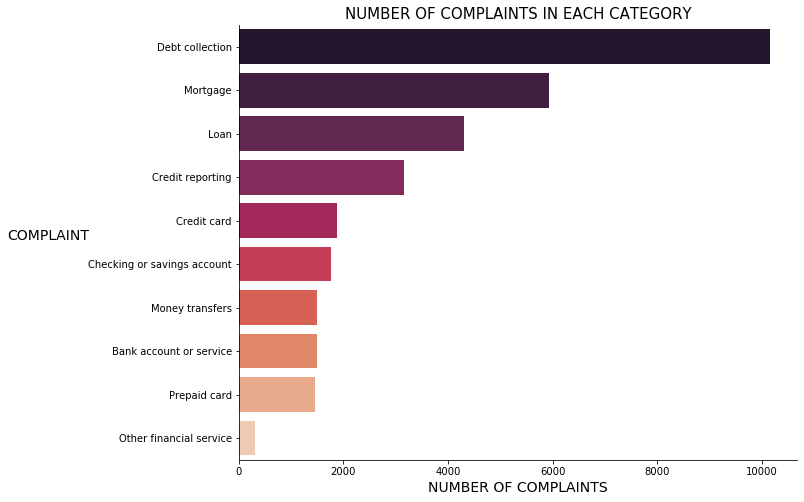

In [130]:
fig, ax = plt.subplots(figsize=(10,8))

ax = sns.countplot(y='PRODUCT', 
                   data=df_product_and_complaint_reduced, 
                   order=df_product_and_complaint_reduced['PRODUCT'].value_counts().index,
                   palette='rocket'        # change the color of this graph LATER
                  )

ax.set_title('NUMBER OF COMPLAINTS IN EACH CATEGORY',size=15)

# Setting labels
# Dealing with y-labels
ax.set_ylabel('COMPLAINT', rotation=0, labelpad=40, size=14)
              
# Dealing with x-labels
ax.set_xlabel('NUMBER OF COMPLAINTS', size=14)

sns.despine()
plt.savefig('freq_of_removed_classes_and_reduced_observations.png', transparency=True)

---------------------------------------------------------
LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:
---------------------------------------------------------


Train/Cross-Validation Test Accuracy Score (also micro F1) for LogisticRegression: 0.8286
Final Test Accuracy Score (also micro F1) for LogisticRegression: 0.8274


Macro Precision Score for LogisticRegression: 0.7874
Macro Recall Score for LogisticRegression: 0.6894
Macro F1 score = 0.7044


Micro Precision Score for LogisticRegression: 0.8274
Micro Recall Score for LogisticRegression: 0.8274
Micro F1 score = 0.8274


Weighted Precision Score for LogisticRegression: 0.8229
Weighted Recall Score for LogisticRegression: 0.8274
Weighted F1 score = 0.8197


Classification report for LogisticRegression (1-gram):
                              precision    recall  f1-score   support

            Debt collection       0.60      0.39      0.47       298
           Credit reporting       0.68      0.64      0.66       352
  

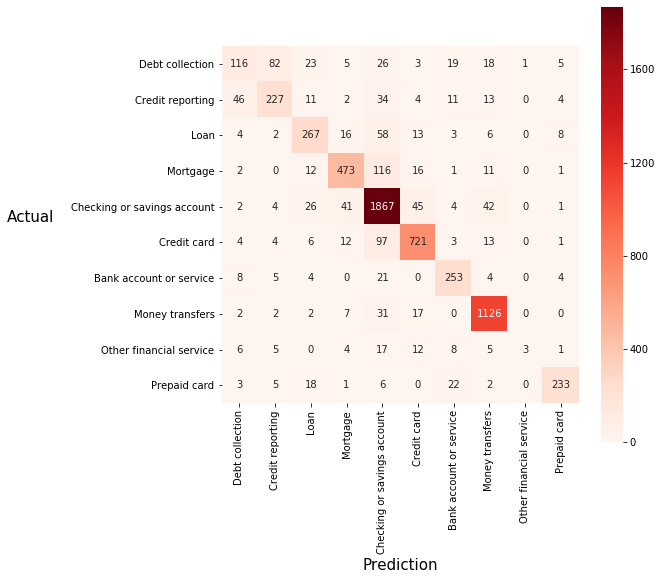

In [142]:
with open('results_highest_accuracy.pickle', 'rb') as to_read:
    results_highest_accuracy = pickle.load(to_read)

results_highest_accuracy

# Score model
print("---------------------------------------------------------")
print("LogisticRegression (1-gram) 80% TRAIN/20% TEST SCORES:")
print("---------------------------------------------------------")
print('\n')
print('Train/Cross-Validation Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(results_highest_accuracy.Accuracy.max()))
print('Final Test Accuracy Score (also micro F1) for LogisticRegression: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('\n')
print('Macro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='macro')))
print('\n')
print('Micro Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='micro')))
print('\n')
print('Weighted Precision Score for LogisticRegression: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall Score for LogisticRegression: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1 score = {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\n')
print('Classification report for LogisticRegression (1-gram):\n {}'.format(classification_report(y_test, 
                                                                                             y_pred,
                                                                                             target_names=df_product_and_complaint_reduced.PRODUCT.unique())))
print('Confusion Matrix for LogisticRegression (1-gram):\n'.format(conf_matrix(y_test, y_pred)))

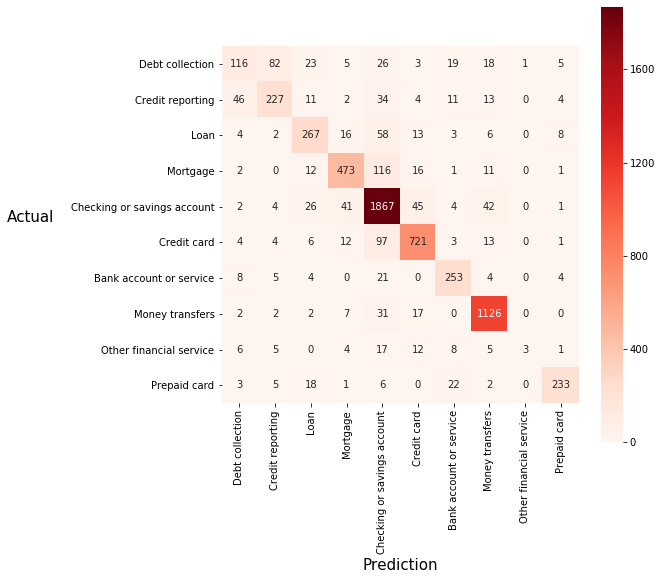

In [11]:
conf_matrix(y_test, y_pred)
plt.savefig('confusion_matrix', transparent=True)

In [14]:
# Although our model is not going to be correct 100% of the time, it does a pretty good job

In [76]:
# Just leaving this here for presentation purposes. 
# However, we are already doing the stratified split in the function itself

# # StratifiedKFold
# ## We now want to do stratified kfold to preserve the proportion of the category imbalances 
# # (number is split evenly from all the classes)
# kf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=seed)

# Section 5: Testing out Predictions on Random Complaints

In [2]:
# These are the ONLY packages we need to use from this point forward!
import pandas as pd
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
# Loading our saved models
# Consider training on the whole data instead now?
with open('fitted_tfidf_to_use.pickle', 'rb') as to_read:  # loading the fitted tfidf with our 80% trained data
    fitted_tfidf_to_use = pickle.load(to_read)
    
with open('logit_finalized.pickle', 'rb') as to_read:  # loading our model
    logit_finalized = pickle.load(to_read)

## Section 5.1: Random Complaint 1

In [4]:
# Using our models

complaint = """
omg where is my money
aosidnoiandnaiosdnasd This is bullshit!! where is my money!!!
I TRANSFERRED IT BUT IT JUST DISAPPEARED INTO THIN AIR.
WHAT KIND OF A BANK ARE YOU?
ARE YOU A BANK OR A THIEF?"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint = fitted_tfidf_to_use.transform([complaint])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint)
y_customized_prediction[0]

'Money transfers'

## Section 5.1: Random Complaint 2

In [19]:
# Using our models

complaint_2 = """
I borrowed money from you guys but it seems that the interest terms are unclear?
Please shed some more light on this because i seem to be overcharged this month and I don't want to pay more than I should
"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_2 = fitted_tfidf_to_use.transform([complaint_2])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_2)
y_customized_prediction

array(['Debt collection'], dtype=object)

In [ ]:
# Not bad! Our model actually does do a pretty good job at predicting

## Section 5.2: Random Complaint 3 with no relevance at all

What about _completely_ irrelevant topics?

In [5]:
# Using our models

complaint_3 = """
I love macdonalds"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_3 = fitted_tfidf_to_use.transform([complaint_3])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_3)
y_customized_prediction

array(['Debt collection'], dtype=object)

## Section 5.3: Random Complaint 4 with no relevance at all

In [6]:
# Using our models

complaint_4 = """
Pair programming is not fun"""

# After fitting the tfidf vectorizor, then you can do transforms!
new_vectorized_complaint_4 = fitted_tfidf_to_use.transform([complaint_4])

# Fitting vectorized complaint into model
y_customized_prediction = logit_finalized.predict(new_vectorized_complaint_4)
y_customized_prediction

array(['Debt collection'], dtype=object)

### Comments:
It seems like everything that has no relevance tends to be classified as Debt Collection.  
So yes - there are cases therein which the model can incorrectly classify the Complaint.  
However, although our model is not going to be correct 100% of the time, it does do a pretty good job.  
It can handle very weird complaints where we throw in a complain that doesn't make a lot of sense.  
  
### Breaking our Model down:
It's great that we know that our model can do classifcation, but HOW does it do it? Let's dissect it and check what key words the model looks out for to classify a complaint.

# Section 6: Highest Occuring Words in each column

In [36]:
# tfidf2 = unigram and bigram
tfidf2 = TfidfVectorizer(sublinear_tf=True, # set to true to scale the term frequency in logarithmic scale.
                        min_df=5, 
                        ngram_range=(1,2), # we consider unigrams and bigrams
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf2.fit_transform(df_product_and_complaint_reduced.CONSUMER_COMPLAINT).toarray()
# Labelling our data
labels = df_product_and_complaint_reduced.PRODUCT_ID

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 31942 complaints is represented by 86133 features (TF-IDF score of unigrams and bigrams)


In [163]:
category_to_id

{'Debt collection': 0,
 'Credit reporting': 1,
 'Loan': 2,
 'Mortgage': 3,
 'Checking or savings account': 4,
 'Credit card': 5,
 'Bank account or service': 6,
 'Money transfers': 7,
 'Other financial service': 8,
 'Prepaid card': 9}

In [40]:
# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf2.get_feature_names())[indices]
    
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: checking, bank, overdraft
  * Most Correlated Bigrams are: scottrade bank, overdraft fees, checking account

==> Checking or savings account:
  * Most Correlated Unigrams are: bank, deposit, checking
  * Most Correlated Bigrams are: 00 bonus, overdraft fees, checking account

==> Credit card:
  * Most Correlated Unigrams are: rewards, macy, card
  * Most Correlated Bigrams are: balance transfer, annual fee, credit card

==> Credit reporting:
  * Most Correlated Unigrams are: transunion, experian, equifax
  * Most Correlated Bigrams are: equifax xxxx, trans union, credit report

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collection, collect debt, collection agency

==> Loan:
  * Most Correlated Unigrams are: student, loans, navient
  * Most Correlated Bigrams are: loan forgiveness, student loans, student loan

==> Money transfers:
  * Most Correlate

### Section 69.1: Word Cloud (Most frequently occuring words depicted in a picture)

# Section 7: Flask App

In [ ]:
## Do a flask app that returns the predicted category
# and the percentage probability of each category
# with an input

### Please refer to the flask_app folder if you are interested in finding out how to create the app!